<a href="https://colab.research.google.com/github/YanzhaoZ/PreBit/blob/main/price_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [170]:
!pip install yfinance
import yfinance as yf
import pandas as pd


In [229]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


# Loading the Price Data

In [172]:
start_date ='2015-01-01'
end_date = '2019-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

#relative_price, will calculate the change in % compared to the day before. 
relative_price = (price/price.shift(1)-1)

[*********************100%***********************]  1 of 1 completed


In [173]:
price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [174]:
relative_price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.019835,-0.014343,-0.001395,0.002492,0.002492,-0.021888
2015-01-03,0.002442,-0.002181,-0.103593,-0.107767,-0.107767,3.205047
2015-01-04,-0.107036,-0.088593,-0.083499,-0.060079,-0.060079,0.682956
2015-01-05,-0.057130,-0.030947,0.029005,0.038907,0.038907,-0.209716


In [175]:
#add in the label
#I can start with the % change of the daily closing price, then create labels.
#another way could be to look at the next day High vs today Close.  
price_2= price.Close.to_frame()
price['change']=price_2.apply(lambda x: x.shift(-1)/x -1)
price['change_label']=price['change'].apply (lambda x: x>0 )
#NaN > 0 gives false? Perhaps I could drop na before this step? 


#copy the label to relative_price part as well. 
relative_price['change'] = price['change']
relative_price['change_label']=price['change_label']

In [176]:
print (len(price),len(relative_price))

1826 1826


In [177]:
price = price.dropna()
relative_price = relative_price.dropna()

In [178]:
#price would lose the last day, because no information on next day price to create the label
#relative price, would ALSO lose the first day, because no information to calculate the relative changes .
print (len(price),len(relative_price))

1825 1824


In [179]:
relative_price[5:12]

,Open,High,Low,Close,Adj Close,Volume,change,change_label
Date,,,,,,,,
2015-01-07,0.041754,0.038953,0.038075,0.028471,0.028471,0.069738,-0.037331,False
2015-01-08,0.028167,-0.015461,-0.003194,-0.037331,-0.037331,-0.196419,0.024913,True
2015-01-09,-0.039954,-0.010271,-0.005819,0.024913,0.024913,-0.063250,-0.053759,False
2015-01-10,0.017423,-0.010261,-0.023409,-0.053759,-0.053759,-0.184538,-0.033246,False
2015-01-11,-0.044187,-0.029463,-0.032584,-0.033246,-0.033246,0.192377,0.008040,True
2015-01-12,-0.030815,-0.026588,0.000607,0.008040,0.008040,0.037334,-0.156593,False
2015-01-13,0.004689,-0.014423,-0.170792,-0.156593,-0.156593,2.858196,-0.211449,False


In [180]:
relative_price['change_label'].value_counts()

True     1000
False     824
Name: change_label, dtype: int64

# Adding in technical indicators

In [181]:
price.head()

,Open,High,Low,Close,Adj Close,Volume,change,change_label
Date,,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,0.002492,True
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,-0.107767,False
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,-0.060079,False
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,0.038907,True
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,0.042682,True


In [182]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    #dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    #dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset["Close"].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [183]:
test_df = pd.DataFrame({'B':[1,2,3,4,5,6,7]})

In [184]:
pd.__version__

'1.1.4'

In [185]:
price_processed = get_technical_indicators(price)
#price.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [186]:
price_processed.tail()

,Open,High,Low,Close,Adj Close,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Date,,,,,,,,,,,,,,,,,
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034,0.007062,True,7301.978167,7262.871908,7358.836553,7262.697426,-96.139127,206.236480,7675.344867,6850.398948,7258.142218
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360995,0.003827,True,7312.159877,7250.638184,7353.744096,7266.911419,-86.832677,193.541738,7637.721659,6863.554708,7279.439659
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,0.014302,True,7330.278669,7239.293062,7351.095662,7274.769698,-76.325964,178.778125,7596.849312,6881.736812,7305.140042
2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832,7422.652832,22445257701,-0.017468,False,7317.573521,7232.545805,7356.396193,7297.520949,-58.875243,179.979293,7592.504391,6872.587219,7383.481902
2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117,7292.995117,22874131671,-0.013629,False,7308.625907,7227.407506,7351.699817,7296.824667,-54.875149,180.244700,7587.896906,6866.918105,7323.157379


In [187]:
price_processed = price_processed.dropna()
price_processed.isnull().value_counts()

Open   High   Low    Close  Adj Close  Volume  change  change_label  ma7    ma21   26ema  12ema  MACD   20sd   upper_band  lower_band  ema  
False  False  False  False  False      False   False   False         False  False  False  False  False  False  False       False       False    1805
dtype: int64

In [188]:
price_processed.head()
#although I'm not very sure about how 26ema can be calculated when I don't have 26 days of data before this day ? 
#and ema, with this particular set up, seems a bit off? : https://stackoverflow.com/questions/37924377/does-pandas-calculate-ewm-wrong
#the link above provides an alternate view, but I think with the amount of days I have, it shouldn't really matter that much. 
#Let's keep going w/o it first. 

,Open,High,Low,Close,Adj Close,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Date,,,,,,,,,,,,,,,,,
2015-01-21,211.378006,227.787994,211.212006,226.897003,226.897003,29924600,0.028687,True,211.516142,252.197332,237.296354,225.220423,-12.075931,39.542978,331.283287,173.111376,221.826443
2015-01-22,227.322006,237.018997,226.434006,233.406006,233.406006,33544600,-0.002258,False,214.882143,248.347666,236.943225,226.512490,-10.430735,36.472461,321.292588,175.402743,229.546152
2015-01-23,233.516998,234.845001,225.195999,232.878998,232.878998,24621700,0.064274,True,218.422429,244.435617,236.580372,227.513418,-9.066953,35.544410,315.524437,173.346798,231.768049
2015-01-24,232.699997,248.210007,230.022003,247.847000,247.847000,24782500,0.023688,True,225.363429,242.852998,237.571188,230.699476,-6.871711,35.208124,313.269246,172.436750,242.487350
2015-01-25,247.352005,255.074005,243.889999,253.718002,253.718002,33582700,0.077862,True,231.560429,242.354093,238.971756,234.296011,-4.675745,34.492524,311.339142,173.369045,249.974451


In [189]:
#visualise the chart
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    #plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

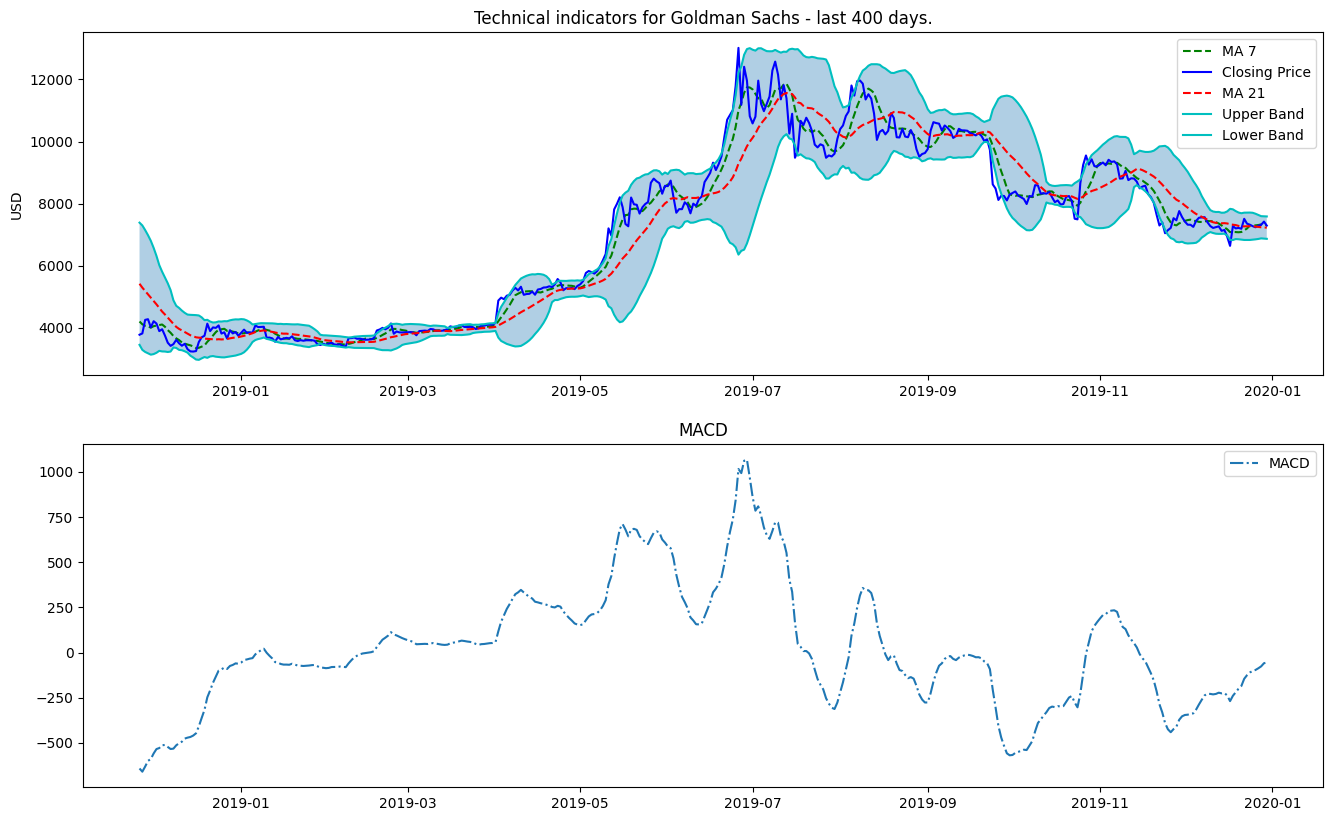

In [190]:
plot_technical_indicators(price_processed, 400)

In [191]:
price_processed.head()

,Open,High,Low,Close,Adj Close,Volume,change,change_label,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema
Date,,,,,,,,,,,,,,,,,
2015-01-21,211.378006,227.787994,211.212006,226.897003,226.897003,29924600,0.028687,True,211.516142,252.197332,237.296354,225.220423,-12.075931,39.542978,331.283287,173.111376,221.826443
2015-01-22,227.322006,237.018997,226.434006,233.406006,233.406006,33544600,-0.002258,False,214.882143,248.347666,236.943225,226.512490,-10.430735,36.472461,321.292588,175.402743,229.546152
2015-01-23,233.516998,234.845001,225.195999,232.878998,232.878998,24621700,0.064274,True,218.422429,244.435617,236.580372,227.513418,-9.066953,35.544410,315.524437,173.346798,231.768049
2015-01-24,232.699997,248.210007,230.022003,247.847000,247.847000,24782500,0.023688,True,225.363429,242.852998,237.571188,230.699476,-6.871711,35.208124,313.269246,172.436750,242.487350
2015-01-25,247.352005,255.074005,243.889999,253.718002,253.718002,33582700,0.077862,True,231.560429,242.354093,238.971756,234.296011,-4.675745,34.492524,311.339142,173.369045,249.974451


# Format data for model

In [192]:
#now perhaps convert them to a list, and then tensor, to proceed to process the price data? 

x_input=price_processed.drop(['change','change_label'],axis=1).values

# scaler = MinMaxScaler()
# x_input= scaler.fit_transform(x_input)
x_input=x_input.tolist()

x_label=price_processed['change_label'].values
x_label=x_label.reshape(-1,).tolist()
#try to encode label 
x_label = [1 if x else 0 for x in x_label]


In [193]:
x_input[0]

[211.3780059814453,
 227.78799438476562,
 211.21200561523438,
 226.89700317382812,
 226.89700317382812,
 29924600.0,
 211.5161416190011,
 252.19733174641928,
 237.29635350176954,
 225.22042289269598,
 -12.075930609073566,
 39.54297772854353,
 331.28328720350635,
 173.1113762893322,
 221.8264434798479]

In [194]:
#roe relative price 
# x_input = relative_price.drop(['change','change_label'],axis = 1).values


# # x_input= min_max_scaler.fit_transform(x_input)
# x_input=x_input.tolist()

# x_label=relative_price['change_label'].values
# x_label=x_label.reshape(-1,).tolist()
# #try to encode label 
# x_label = [1 if x else 0 for x in x_label]

In [195]:
x_input[0],x_label[0]

([211.3780059814453,
  227.78799438476562,
  211.21200561523438,
  226.89700317382812,
  226.89700317382812,
  29924600.0,
  211.5161416190011,
  252.19733174641928,
  237.29635350176954,
  225.22042289269598,
  -12.075930609073566,
  39.54297772854353,
  331.28328720350635,
  173.1113762893322,
  221.8264434798479],
 1)

In [196]:
def process(data, window_size):
    output = []
    for i in range(window_size-1, len(data)):
        raw_data = data[i-window_size+1:i+1]
        output.append(raw_data)
    return output

window_size = 10
x_processed = process(x_input, 10)
split = round(len(x_processed)*0.7)
x_train = x_processed[:split]
x_eval = x_processed[split:]
x_train = torch.tensor(x_train, dtype=torch.float)
x_lab = torch.tensor(x_label[window_size-1:window_size-1+split],dtype=torch.float)


x_eval = torch.tensor(x_eval, dtype=torch.float)
x_lab_eval = torch.tensor(x_label[window_size-1+split:],dtype=torch.float)

print(x_train.size())
print(x_lab.size())
print(x_train[0])
print(x_label[0])
print(x_train.type())
print(x_lab.type())
print(x_eval.size())
print(x_lab_eval.size())

torch.Size([1257, 10, 15])
torch.Size([1257])
tensor([[ 2.1138e+02,  2.2779e+02,  2.1121e+02,  2.2690e+02,  2.2690e+02,
          2.9925e+07,  2.1152e+02,  2.5220e+02,  2.3730e+02,  2.2522e+02,
         -1.2076e+01,  3.9543e+01,  3.3128e+02,  1.7311e+02,  2.2183e+02],
        [ 2.2732e+02,  2.3702e+02,  2.2643e+02,  2.3341e+02,  2.3341e+02,
          3.3545e+07,  2.1488e+02,  2.4835e+02,  2.3694e+02,  2.2651e+02,
         -1.0431e+01,  3.6472e+01,  3.2129e+02,  1.7540e+02,  2.2955e+02],
        [ 2.3352e+02,  2.3485e+02,  2.2520e+02,  2.3288e+02,  2.3288e+02,
          2.4622e+07,  2.1842e+02,  2.4444e+02,  2.3658e+02,  2.2751e+02,
         -9.0670e+00,  3.5544e+01,  3.1552e+02,  1.7335e+02,  2.3177e+02],
        [ 2.3270e+02,  2.4821e+02,  2.3002e+02,  2.4785e+02,  2.4785e+02,
          2.4782e+07,  2.2536e+02,  2.4285e+02,  2.3757e+02,  2.3070e+02,
         -6.8717e+00,  3.5208e+01,  3.1327e+02,  1.7244e+02,  2.4249e+02],
        [ 2.4735e+02,  2.5507e+02,  2.4389e+02,  2.5372e+02,  

# Prepare the Model

In [197]:
train_data = x_train
train_label = x_lab

eval_data = x_eval
#print(test_data.size())
eval_label = x_lab_eval
#print(test_label)

# batching  data
batch_size = 64
train_data = TensorDataset(train_data, train_label)
train_loader = DataLoader(train_data, batch_size)
train_batches = [batch for batch in train_loader]

eval_data = TensorDataset(eval_data, eval_label)
eval_loader = DataLoader(eval_data, batch_size) 
eval_batches = [batch for batch in eval_loader]

In [198]:
class OurModel(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel, self).__init__()
        num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(self.hidden_size, 1)
        self.dropout = nn.Dropout()

        #need to change the loss function. 
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        percent_change = self.ff(hn)
        return percent_change


In [199]:
#define model,

model = OurModel(15, 512, 2)

# for i in range(30):
#     for step, batch in enumerate(train_batches):
#         optimizer.step()
#         model.zero_grad()
        
#         data, label = tuple(t for t in batch)
#         model.train()
#         loss = model(data, label)
#         loss.backward()

#     model.eval()
#     output = evaluation(test_loader, model)
#     print('prediction:', output)
#     print(loss)

In [200]:
#define optimizer, loss function
params = model.parameters()
optimizer = optim.Adam(params)
criterion = nn.BCEWithLogitsLoss()

In [201]:
#Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

print (device)

cuda


In [202]:
#check number of parameters. 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,185,153 trainable parameters


In [203]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [204]:
#here, let's try to define a function to get the confusion matrix stats



In [216]:
def train(model, train_batches, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for step, batch in enumerate(train_batches):
        
        optimizer.zero_grad()
        
        data, label = tuple(t for t in batch)

        data = data.to(device)
        label = label.to(device)

        predictions = model(data).squeeze(1)

        loss = criterion(predictions, label)
        #loss = f1_loss(predictions, label)
        
        acc = binary_accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(train_batches), epoch_acc / len(train_batches)

In [206]:
def evaluate(model, eval_batches, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for step, batch in enumerate(eval_batches):

            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)
            
            predictions = model(data).squeeze(1)
            
            loss = criterion(predictions, label)
            
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [215]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_batches, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, eval_batches, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

AssertionError: ignored

In [208]:
len(train_batches)

20

In [209]:
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
  for step, batch in enumerate(eval_batches):
    data, label = (t for t in batch)
    data = data.to(device)
    label = label.to(device)
    predictions = model(data).squeeze(1)
    predictions = torch.sigmoid(predictions)
    predictions = torch.round(predictions)

    predlist=torch.cat([predlist,predictions.view(-1).cpu()])
    lbllist=torch.cat([lbllist,label.view(-1).cpu()])


In [210]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)


[[  0 261]
 [  0 278]]


In [211]:
predlist

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [212]:
lbllist

tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 

# Trying out New Loss function for F1

In [260]:
class OurModel2(nn.Module):
    def __init__(self, input_size,  hidden_size, num_layers):
        super(OurModel2, self).__init__()
        num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(self.hidden_size, 256)
        self.ff2 = nn.Linear(256,2)
        self.dropout = nn.Dropout()

        #need to change the loss function. 
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        percent_change = self.ff(hn)
        percent_change2 = self.ff2(percent_change)
        return percent_change2

model2 = OurModel2(15,512,2)

In [261]:
#define optimizer, loss function
params2 = model2.parameters()
optimizer2 = optim.Adam(params2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)

print (device)

cuda


In [262]:
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()

f1_loss = F1_Loss().cuda()

In [263]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [264]:
def train(model, train_batches, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    for step, batch in enumerate(train_batches):
        
        optimizer.zero_grad()
        
        data, label = tuple(t for t in batch)

        data = data.to(device)
        label = label.to(device)

        predictions = model(data)

        loss = f1_loss(predictions, label.to(torch.int64))
        
        acc = accuracy(predictions, label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_batches), epoch_acc / len(train_batches)

In [265]:
def evaluate(model, eval_batches, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for step, batch in enumerate(eval_batches):

            data, label = tuple(t for t in batch)
            data = data.to(device)
            label = label.to(device)
            
            predictions = model(data)
            
            loss = f1_loss(predictions, label.to(torch.int64))
           
            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(eval_batches), epoch_acc / len(eval_batches)

In [266]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model2, train_batches, optimizer2, criterion)
    valid_loss, valid_acc = evaluate(model2, eval_batches, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	 Train. Loss: 0.507 |  Train. Acc: 52.66%
	 Val. Loss: 0.507 |  Val. Acc: 48.64%
Epoch: 02 | Epoch Time: 0m 0s
	 Train. Loss: 0.504 |  Train. Acc: 52.95%
	 Val. Loss: 0.504 |  Val. Acc: 48.64%
Epoch: 03 | Epoch Time: 0m 0s
	 Train. Loss: 0.506 |  Train. Acc: 51.38%
	 Val. Loss: 0.503 |  Val. Acc: 48.64%
Epoch: 04 | Epoch Time: 0m 0s
	 Train. Loss: 0.506 |  Train. Acc: 53.35%
	 Val. Loss: 0.503 |  Val. Acc: 48.64%
Epoch: 05 | Epoch Time: 0m 0s
	 Train. Loss: 0.500 |  Train. Acc: 55.30%
	 Val. Loss: 0.503 |  Val. Acc: 48.64%
Epoch: 06 | Epoch Time: 0m 0s
	 Train. Loss: 0.507 |  Train. Acc: 52.26%
	 Val. Loss: 0.502 |  Val. Acc: 51.36%
Epoch: 07 | Epoch Time: 0m 0s
	 Train. Loss: 0.507 |  Train. Acc: 52.56%
	 Val. Loss: 0.503 |  Val. Acc: 51.36%
Epoch: 08 | Epoch Time: 0m 0s
	 Train. Loss: 0.506 |  Train. Acc: 51.44%
	 Val. Loss: 0.514 |  Val. Acc: 51.36%
Epoch: 09 | Epoch Time: 0m 0s
	 Train. Loss: 0.506 |  Train. Acc: 50.97%
	 Val. Loss: 0.506 |  Val. Acc: